# PSF Check

In [1]:
from gammapy.cube import PSFMap
from gammapy.irf import EnergyDependentTablePSF

In [162]:
from pathlib import Path
import copy

from astropy.coordinates import SkyCoord
from astropy.table import Table
from gammapy.maps import WcsGeom
from gammapy.modeling.models import (
    Models,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
)
from gammapy.data import GTI, Observation, EventList
from gammapy.maps import MapAxis, WcsGeom, Map, MapCoord
from gammapy.maps.profile import ImageProfile, ImageProfileEstimator
from gammapy.irf import EnergyDispersion2D, PSF3D, EnergyDependentMultiGaussPSF, load_cta_irfs

from gammapy.cube import (
    MapDataset,
    MapDatasetEventSampler,
    MapDatasetMaker,
)
from gammapy.utils.random import get_random_state


In [3]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import astropy.units as u


In [4]:
def get_filename_dataset(livetime):
    filename = f"data/dataset_{livetime.value:.0f}{livetime.unit}.fits.gz"
    return BASE_PATH / filename


def get_filename_events(filename_dataset, filename_model, obs_id):
    obs_id=int(obs_id)
    model_str = filename_model.name.replace(filename_model.suffix, "")
    filename_events = filename_dataset.name.replace("dataset", "events")
    filename_events = BASE_PATH / f"data/models/{model_str}/" / filename_events
    filename_events = filename_events.name.replace(".fits.gz", f"_{obs_id:04d}.fits.gz")
    path = BASE_PATH / f"data/models/{model_str}/" / filename_events
    return path


In [5]:
def gaussian(x, amp, wid):
    return amp * np.exp(-(x)**2 / (2*wid**2.))


In [6]:
BASE_PATH = Path("../make.py").parent

In [7]:
model = "point-pwlsimple"
filename_model = BASE_PATH / f"models/{model}.yaml"


In [8]:
IRF_FILE = "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
POINTING = SkyCoord(0.0, 0.0, frame="galactic", unit="deg")
LIVETIME = 10 * u.hr
GTI_TABLE = GTI.create(start=0 * u.s, stop=LIVETIME.to(u.s))

# dataset config
ENERGY_AXIS = MapAxis.from_energy_bounds("0.1 TeV", "100 TeV", nbin=10, per_decade=True)
ENERGY_AXIS_TRUE = MapAxis.from_energy_bounds("0.03 TeV", "300 TeV", nbin=20, per_decade=True)
MIGRA_AXIS = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

WCS_GEOM = WcsGeom.create(
    skydir=POINTING, width=(0.15, 0.15), binsz=0.01, frame="galactic", axes=[ENERGY_AXIS]
)


### Create the dataset

In [396]:
spatial_model = PointSpatialModel(lon_0="0.0deg", lat_0="0.0deg", frame="galactic")
spectral_model = PowerLawSpectralModel(amplitude="1e-11 cm-2 s-1 TeV-1")
skymodel = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

#Now we create a reference exposure map, we use to evaluate the model:
exposure = Map.create(
    binsz=0.02,
    map_type='wcs',
    skydir=POINTING,
    width="5 deg",
    axes=[ENERGY_AXIS_TRUE],
    frame="galactic", unit="cm2 s"
)

exposure.data = 1e10 * 1000 * np.ones(exposure.data.shape)

evaluator = MapDataset.create(WCS_GEOM, models=skymodel)
evaluator.exposure.data += 1e13
n=evaluator.npred()
np.sum(n.data)

random_state = get_random_state(0)
n_events = random_state.poisson(np.sum(n.data))
coords = npred.sample_coord(n_events, random_state)

### DOESN'T WORK....

/Users/fabio/LAVORO/CTA/GAMMAPY/GIT/gammapy/gammapy/cube/psf_kernel.py:109: RuntimeWarning: invalid value encountered in true_divide
  img += vals.value / vals.sum().value


0.0

#### START HERE

In [14]:
irfs = load_cta_irfs(IRF_FILE)

observation = Observation.create(
                                 obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
                                 )

empty = MapDataset.create(WCS_GEOM, energy_axis_true=ENERGY_AXIS_TRUE, migra_axis=MIGRA_AXIS)
maker = MapDatasetMaker(selection=["exposure"])
dataset = maker.run(empty, observation)

In [15]:
models = Models.read(filename_model)
dataset.models = models

In [16]:
evaluator=dataset._evaluators[0]
npred = evaluator.compute_npred()

In [131]:
# a=npred.sum_over_axes()

#### Simulate the events

In [18]:
random_state = get_random_state(0)
n_events = random_state.poisson(np.sum(npred.data))
coords = npred.sample_coord(n_events, random_state)

In [19]:
coord = SkyCoord(coords['lon'], coords['lat'], frame='galactic')

In [20]:
ra,dec = coord.icrs.ra.value,coord.icrs.dec.value 

#### Pointlike source distribution

In [21]:
model = PointSpatialModel(lon_0="0.01deg", lat_0="0.01deg", frame="galactic",)

width=0.15
bins=0.01
geom = WcsGeom.create(
    skydir=SkyCoord("0.0d 0.0d", frame="galactic"), width=(width, width), binsz=bins
)

#### Compare the 2Dhistograms

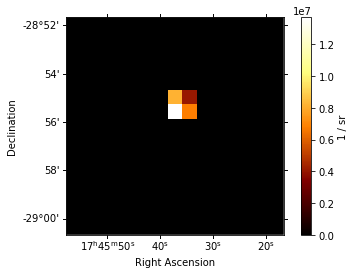

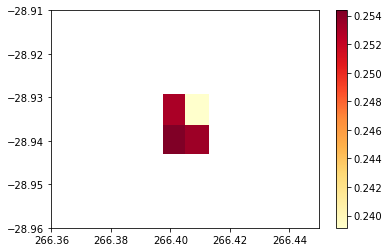

In [22]:
#plot the point source
model.plot(geom=geom, add_cbar=True)

#plot the npred histogram
plt.subplots(1,1)
weights = np.ones_like(ra)/float(len(ra))
plt.hist2d(ra,dec, bins=2, 
           cmap=plt.cm.YlOrRd, weights=weights,
          )
plt.xlim(266.36,266.45)
plt.ylim(-28.96,-28.91)
plt.colorbar()

### Create a fake PSF

In [281]:
psf_gauss = EnergyDependentMultiGaussPSF.read(filename=IRF_FILE, hdu="POINT SPREAD FUNCTION")
test = copy.deepcopy(psf_gauss.sigmas)
psf_gauss.sigmas[0] = (psf_gauss.sigmas[0] / psf_gauss.sigmas[0]) * 0.1
test[0][:] = 0.1
psf_gauss.norms[0][:] = 1
psf_3d = psf_gauss.to_psf3d(rad=np.linspace(0, 1, 100) * u.deg)

In [282]:
# print(psf_gauss.sigmas[0])
# print(test[0])
# np.array(psf_gauss.sigmas) - np.array(test)

##### Create the dataset

In [283]:
irfs = load_cta_irfs(IRF_FILE)

irfs['psf'] = psf_3d

observation = Observation.create(
                                 obs_id=1001, pointing=POINTING, livetime=LIVETIME*10, irfs=irfs
                                 )

empty = MapDataset.create(WCS_GEOM, energy_axis_true=ENERGY_AXIS_TRUE, migra_axis=MIGRA_AXIS)
maker = MapDatasetMaker(selection=["exposure", "psf"])
dataset = maker.run(empty, observation)

##### Simulate the events

In [284]:
models = Models.read(filename_model)
dataset.models = models
observation = Observation.create(
    obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
)

sampler = MapDatasetEventSampler(random_state=0)
events = sampler.run(dataset, observation)
tab=copy.deepcopy(events)

In [285]:
# temp=copy.deepcopy(tab.table['RA','DEC','ENERGY'])

In [286]:
tab.table = tab.table['RA','DEC','ENERGY']

In [287]:
# tab.table

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x123ac8ba8>)

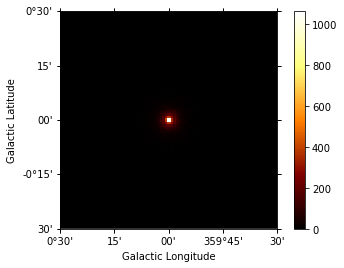

In [288]:
counts = Map.create(frame="galactic", skydir=(0, 0.), binsz=0.01, npix=(100, 100))
counts.fill_events(tab)
counts.plot(add_cbar=True)

In [289]:
p = ImageProfileEstimator(method='sum', axis='radial', center=POINTING)
profile = p.run(counts)

In [295]:
index1 = np.where(profile.table['profile']>0)
dr1 = (profile.table['x_max']-profile.table['x_min'])[index1]
x1 = profile.table['x_ref'][index1]
y1 = profile.table['profile'][index1]*2*np.pi*x1*dr1
yerr1 = y1**0.5

In [296]:
init_vals = [6, 0.1]
best_vals, covar = curve_fit(gaussian, x1[2:], 
                             (y1[2:]), 
                             p0=init_vals, 
                             sigma=yerr1[2:])

print("############")
print(f"This is the normalization: {best_vals[0]} +\- {covar[0,0]**0.5}")
print(f"This is the sigma: {best_vals[1]} +\- {covar[1,1]**0.5}")
print("############")

############
This is the normalization: 4.500840150393922 +\- 0.19945403358503447
This is the sigma: 0.12575704539692084 +\- 0.003278473723865074
############


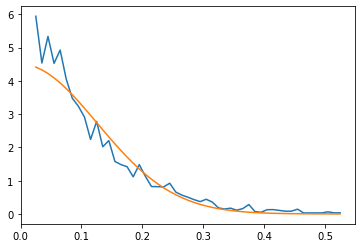

In [297]:
plt.plot(x1[2:], y1[2:])
plt.plot(x1[2:], gaussian(x1[2:],*best_vals))
plt.show()

#### Check sample_psf_coord()

In [298]:
table = Table()

In [299]:
n_events = int(len(events.table))
table['RA_TRUE'] = np.ones(n_events)*266.40498829 * u.deg
table['DEC_TRUE'] = np.ones(n_events)*-28.93617776 * u.deg
table['ENERGY_TRUE'] = events.table['ENERGY_TRUE']
table = EventList(table)

In [300]:
sampler = MapDatasetEventSampler(random_state=0)
evt_psf_mod = sampler.sample_psf(dataset.psf, table)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x11f45ba20>)

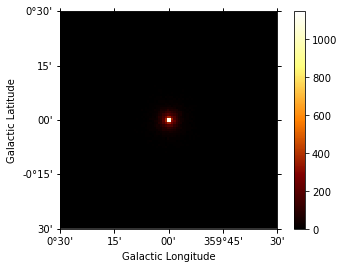

In [301]:
counts2 = Map.create(frame="galactic", skydir=(0, 0.), binsz=0.01, npix=(100, 100))
counts2.fill_events(evt_psf_mod)
counts2.plot(add_cbar=True)

In [302]:
p = ImageProfileEstimator(method='sum', axis='radial', center=POINTING)
profile = p.run(counts2)

In [303]:
index2 = np.where(profile.table['profile']>0)
dr2 = (profile.table['x_max']-profile.table['x_min'])[index2]
x2 = profile.table['x_ref'][index2]
y2 = profile.table['profile'][index2]*2*np.pi*x2*dr2
yerr2 = y2**0.5

In [304]:
init_vals = [6, 0.1]
best_vals, covar = curve_fit(gaussian, x2[2:], 
                             (y2[2:]), 
                             p0=init_vals, 
                             sigma=yerr2[2:])

print("############")
print(f"This is the normalization: {best_vals[0]} +\- {covar[0,0]**0.5}")
print(f"This is the sigma: {best_vals[1]} +\- {covar[1,1]**0.5}")
print("############")

############
This is the normalization: 4.536487704160845 +\- 0.21069241054066848
This is the sigma: 0.12255440957273175 +\- 0.003363419659192104
############


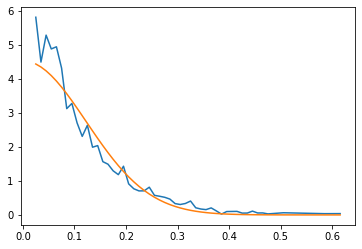

In [305]:
plt.plot(x2[2:], y2[2:])
plt.plot(x2[2:], gaussian(x2[2:],*best_vals))
plt.show()

#### Comparing 1D histograms

In [306]:
models = Models.read(filename_model)
dataset.models = models
sampler = MapDatasetEventSampler(random_state=0)
observation = Observation.create(
    obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
)

events = sampler.run(dataset, observation)

In [307]:
src_pos = SkyCoord(0.0*u.deg, 0.0*u.deg, frame='galactic')
evt_pos = SkyCoord(events.table['RA'], events.table['DEC'], frame='icrs')
evt_pos_psf_mod = SkyCoord(evt_psf_mod.table['RA'], evt_psf_mod.table['DEC'], frame='icrs')
sep = src_pos.separation(evt_pos).value
sep_other = src_pos.separation(evt_pos_psf_mod).value

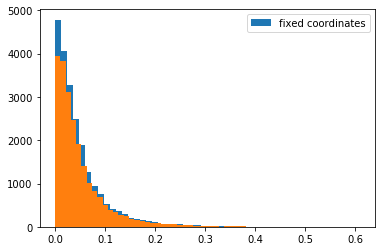

In [308]:
plt.hist(sep_other, bins=50, label='fixed coordinates')
plt.hist(sep, bins=50, label='')
# plt.plot(x[2:], gaussian(x[2:],5000,0.1))
plt.legend()

### Compare the npred profile with the simulated events

In [310]:
evaluator=dataset._evaluators[0]
npred = evaluator.compute_npred()

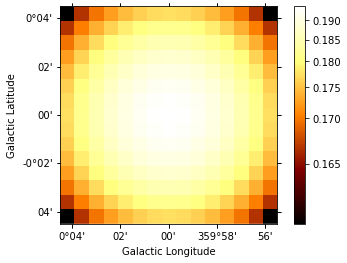

In [311]:
npred.plot_interactive(add_cbar=True)

In [312]:
p = ImageProfileEstimator(method='sum', axis='radial', center=POINTING)
profile = p.run(npred)

In [313]:
profile.table

x_min,x_max,x_ref,profile
deg,deg,deg,
float64,float64,float64,float64
0.0,0.01,0.005,209.60005985945463
0.01,0.02,0.015,1532.412329427898
0.02,0.03,0.025,3078.4142928384244
0.03,0.04,0.035,1941.9929819218814
0.04,0.05,0.045,2801.861620316282
0.05,0.06,0.055,1978.7432432007045
0.06,0.07,0.065,1577.848330724053
0.07,0.08,0.07500000000000001,1461.8966257558204


In [397]:
index3 = np.where(profile.table['profile']>0)
dr3 = (profile.table['x_max']-profile.table['x_min'])[index3]
x3 = profile.table['x_ref'][index3]
y3 = profile.table['profile'][index3]#*2*np.pi*x3*dr3
yerr3 = y3**0.5

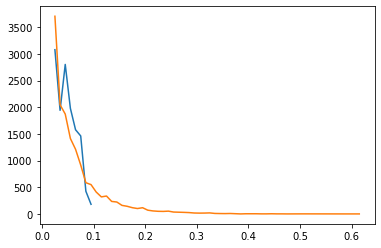

In [400]:
#compare the npred profile with the simulated events
plt.plot(x3[2:], y3[2:])
plt.plot(x2[2:], y2[2:]/(2*np.pi*x2[2:]*dr2[2:]))
